In [1]:
import io, pstats, os, json, PIL, cProfile
import matplotlib.pyplot as plt 
import numpy as np 

from src.corrector import DistortionAdjustment_Multiscale, DistortionAdjustment
from src.classGrid import Grid

## Define settings

In [ ]:
"""
A large array of SEM images, each suffering from unknown distortions
""" 

parameters = {
    # Directory containing input images
    "dire"                 :  'C:\\Users\\mbcx9rt5\\Desktop\\Step_1_small\\', 
    # Offset (padding) in x and y directions (in pixels)
    "ox"                   :  20, 
    "oy"                   :  20,    
    # Interpolation methods for each scale level (coarse to fine): 'bilinear', 'cubic-spline'
    "interpolation_scales" :  ['cubic-spline'],   
    # Subsampling factors for each scale level (reduces resolution for faster computation)
    "subsampling_scales"   :  [1], 
    # Gaussian blur standard deviation for each scale level (noise reduction)
    "sigma_gauss_scales"   :  [0.8],  
    # Number of optimization iterations for each scale level
    "Niter_scales"         :  [10], 
    # Distortion modes: 't' (translation), 'd' (distortion), 't+d' (both)
    "modes"                :  't+d', 
    # Convergence tolerance for optimization
    "tol"                  :  1.e-4,
    # Maximum frequency components (Fourier modes) in x and y for distortion basis
    "mx"                   :  [3, 4, 5, 7, 8], 
    "my"                   :  [3, 4, 5, 6, 9],
    # Initial distortion field (None = start from zero/identity)
    "d0"                   :  None, 
}

results_file = 'identif.json'


## Make grid

In [3]:
# Set up parameters for grid creation
parameters['interpolation'] = parameters['interpolation_scales'][0]
parameters['subsampling'] = parameters['subsampling_scales'][0]
parameters['sigma_gaussian'] = parameters['sigma_gauss_scales'][0]
parameters['Niter'] = parameters['Niter_scales'][0]

# Create grid (auto-detects Field_YY_XX.tif tiles)
grid = Grid.CreateGrid(parameters)

grid.SetTranslations()

Auto-detected grid configuration:
  Grid size: 6 x 4 tiles
  Image size: 2048 x 2048 pixels
  Total tiles found: 24


## Identify distortion field

In [4]:
""" Running the identification procedure""" 
cam, images, grid, res_tot = DistortionAdjustment_Multiscale(parameters, cam0=None, images0=None, grid0=grid, epsilon=10)
""" Measured distortion"""
cam.ShowValues() 

#%% 
""" Saving the input parameters and results """
results = {
    "projector":  {'mx': cam.mx,
                   'my': cam.my, 
                   'p' : list(cam.p) }  
}
with open(parameters['dire']+results_file, "w") as json_file:
    json.dump(results, json_file)

*********** SCALE 1 ***********
--GN
Iter #  1 | dp/p=1.24e-04 | mean_std=7.30, max_std=14.32
Iter #  2 | dp/p=8.87e-05 | mean_std=6.53, max_std=12.71
X:  x*y  x**2  y**2  x*y**2  x**3  
 [ 0.96095491 -1.38886575 -2.44645118 -0.76283631  0.29665032]
Y:  x*y  x**2  y**2  x**2*y  y**3  
 [-0.8623951   0.9085085   1.22884343  0.25003751  2.18863333]


In [ ]:
prof = cProfile.Profile()
prof.enable()
DistortionAdjustement_Multiscale(parameters, cam0=None, images0=None, grid0=grid, epsilon=10)
prof.disable()

s = io.StringIO()
pstats.Stats(prof, stream=s).sort_stats('cumtime').print_stats(25)
print(s.getvalue())

## Visualise distortion field

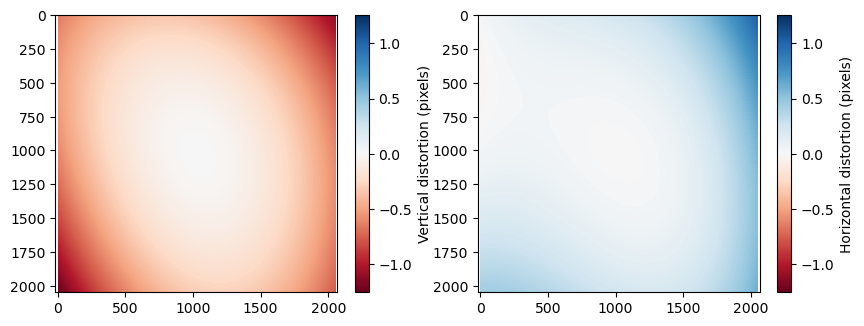

In [5]:
cam.Plot(size=[parameters['sx'], parameters['sy']]) 
#cam.PlotGrid(size=(1024,1024), nelemx=10, alpha=5)
#cam.PlotInverseGrid(size=(1024,1024), nelemx=10, alpha=5)
plt.show() 

## Save corrected images
Necessary if stitching in external software

In [ ]:
#%% 
save_dire = parameters['dire']+'corrected_'
sigma_gaussian = 0 # Parameter for Gaussian bluring of the images 

x = np.arange(parameters['sx'])
y = np.arange(parameters['sy'])
X,Y = np.meshgrid(x,y,indexing='ij')
xtot = X.ravel() 
ytot = Y.ravel() 

Pxtot,Pytot = cam.P(xtot, ytot)


for i,fname in enumerate(os.listdir(parameters['dire'])):
    print(i,fname)
    if fname[-3:] == 'tif': 
        im_new = corrector.Image(parameters['dire']+fname)
        im_new.Load() 
        if im_new.pix.shape == (parameters['sx'],parameters['sy']): 
            im_new.BuildInterp()
            im_new.GaussianFilter(sigma = sigma_gaussian)
            imc = im_new.Interp(Pxtot, Pytot)
            imc = imc.reshape((parameters['sx'],parameters['sy'])) 
            PILimg = PIL.Image.fromarray(np.round(imc).astype("uint8"))
            PILimg.save(save_dire+fname)  
        else: 
            print("Skip file")
    else: 
        print("Skip file")

## Stitching the mosaic

In [ ]:
ims_unc = grid.StitchImages(cam=None, fusion_mode='linear blending', interpolation_order=1) # Stitching the mosaic without correction 
PILimg = PIL.Image.fromarray(np.round(ims_unc).astype("uint8"))
PILimg.save(parameters['dire']+'mosaic'+'_uncorrected'+parameters['extension'])   

Fusing images (linear blending):
[████████████████████████████████████████]100%



In [6]:
print(cam.p)

[ 1.04058158 -1.80200602 -3.61771315 -0.87632889  0.02694321 -0.94936199
  1.2463654   1.93384892  0.09259678  3.99737975]


In [7]:
ims_c = grid.StitchImages(cam= cam, fusion_mode='linear blending') 
PILimg = PIL.Image.fromarray(np.round(ims_c).astype("uint8"))
PILimg.save(parameters['dire']+'mosaic'+'_corrected'+parameters['extension']) 

Fusing images (linear blending):
[████████████████████████████████████████]100%



In [8]:
grid.ExportTile(parameters['dire']+'TileConfiguration.txt')  # Exporting Tile 

In [ ]:
prof = cProfile.Profile()
prof.enable()
grid.StitchImages(fusion_mode='linear blending', interpolation_order=3)
prof.disable()

s = io.StringIO()
pstats.Stats(prof, stream=s).sort_stats('cumtime').print_stats(25)
print(s.getvalue())